# 支持向量机

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 用 Seaborn 画图
import seaborn as sns; sns.set()

## 支持向量机的原理

* 生成分类方法和判别分类方法的区别
    * 生成法：假设每个类的分布
    * 判别法：用一条分割线（二维空间中的直线或者曲线）或者流体形（多维空间中的曲线、曲面等概念的推广）将各种类型分割开

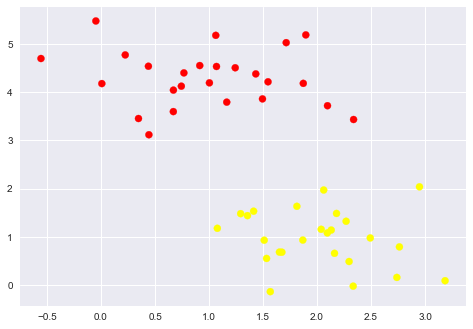

In [70]:
from sklearn.datasets.samples_generator import make_blobs

X,y = make_blobs(n_samples=50, centers=2,
                random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

对于上图，生成方法会假设数据的分布，从而求出特征属于类别的概率，判别方法则是找到一条线，划分两个数据

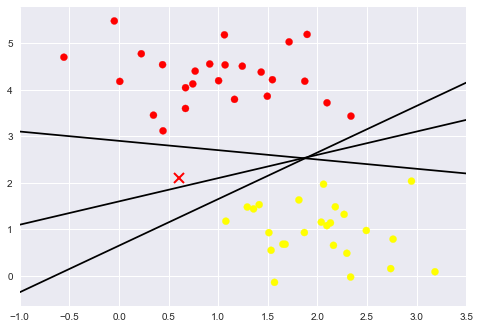

In [71]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10) # 标了一个难以划分的点

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

画一条有宽度的线条

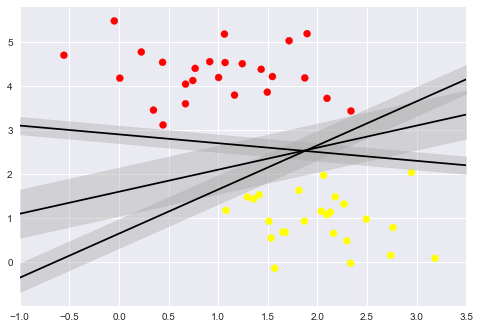

In [72]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)
# 边界并不是机器算出来的，指定了的
plt.xlim(-1, 3.5);

用支持向量机拟合：

In [73]:
from sklearn.svm import SVC # classifier
model = SVC(kernel='linear', C=1e10)  # 线性核，软间隔系数设置很大，条件要求就比较高，越接近于硬间隔
model.fit(X,y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### 普通支持向量机

In [100]:
# 创建一个更好的可视化分类效果
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """二维SVC决策函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 创建评估模型的网格
    x = np.linspace(xlim[0], xlim[1], 30) # x 轴的标记点，计划每一行有 30 个标度，也就是一共 30 列
    y = np.linspace(ylim[0], ylim[1], 30) # y 轴的标记点，计划每一列有 30 个标度，也就是一共 30 行
    X, Y = np.meshgrid(x, y) # 为表格定点做准备，X: x轴每一行对应的标度 Y: y轴上每一行对应的标度 
    xy = np.vstack([X.ravel(), Y.ravel()]).T # 所有网格点坐标
    P = model.decision_function(xy).reshape(X.shape) # 所有网格点结论
    
    # 画出决策边界和边界
    ax.contour(X, Y, P, colors='k',
              levels=[-1,0,1],
              linestyles=['--','-','--']) # 找找P值和 levels 画出相应边界
    
    # 画支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:,0],
                  model.support_vectors_[:,1],
                  s=300, linewidth=1,facecolors='None',
                  edgecolors='black')  # support_vectors_  存储支持向量
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

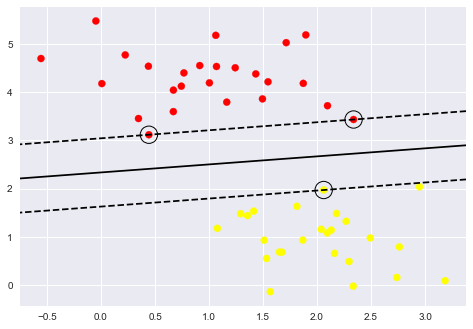

In [101]:
plt.scatter(X[:, 0], X[:, 1],c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

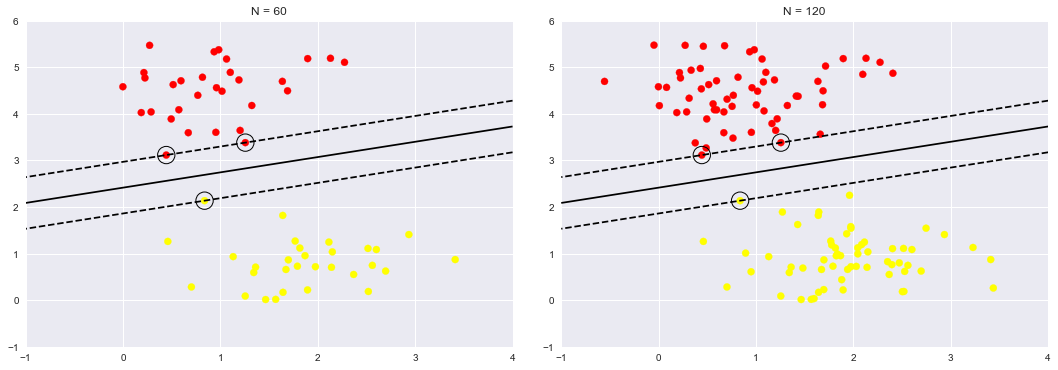

In [102]:
# 对远离边界的点不敏感
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

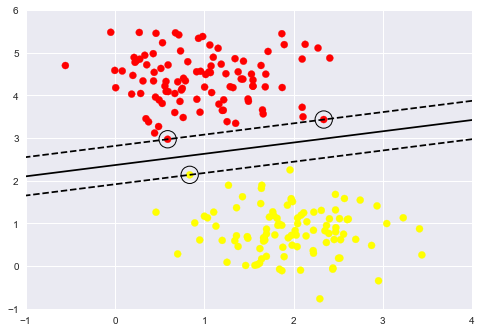

In [104]:
# 动态的观察SVM模型的特点
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,200], ax=fixed(None))

### 超越线性边界：核函数SVM模型

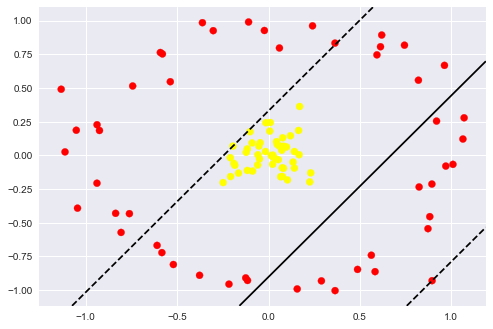

In [105]:
from sklearn.datasets.samples_generator import make_circles
X,y = make_circles(100, factor=0.1, noise=0.1)

clf = SVC(kernel='linear').fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

以上就划分的不是特别好  
一种比较直接的想法就是计算所有数据点的径向基函数

In [108]:
r = np.exp(-(X**2)).sum(1)

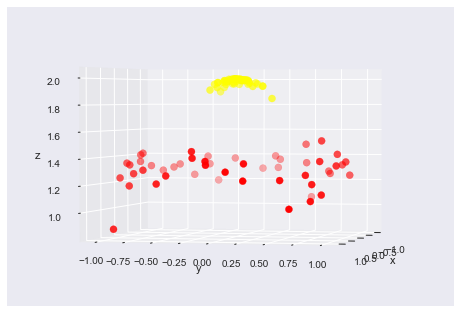

In [109]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=x, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:,0],X[:,1],r,c=y,s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

interact(plot_3D, elev = [-90,90], azip = (-180,180),
        X=fixed(X), y=fixed(y))

增加维度后，数据就线性可分了，以前的数据删不删除无所谓   
在这里，我们需要仔细选择和优化投影方式，如果我们没有将径向基函数集中到正确的位置（非原点集中），就不一定能得到这么干净的分割结果  
由此带出来的核函数方法

In [110]:
clf = SVC(kernel='rbf', C = 1E6)
clf.fit(X,y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

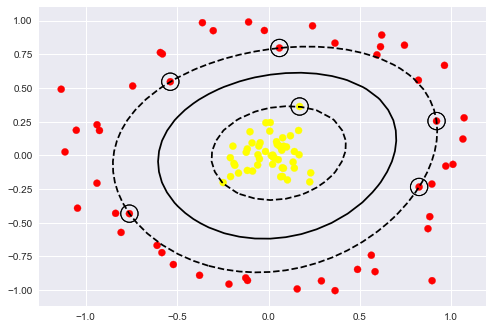

In [111]:
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1],
           s = 300,linewidth=1,facecolors='None',
                  edgecolors='black')

### 核函数

#### 基函数
之前有说到基函数，是一种将变量做衍生的方法，例如：
* 线性基函数： $x \rightarrow (x,x^2,x^3...)$ 
* 高斯基函数： $x \rightarrow e^{-(\epsilon ||x||)^2}$  
这里是存在实打实的映射的

#### 核函数解释
核函数有一种解释是：两个变量在高维空间中的内积，即 $K(x,z)=\Phi(x)^T\Phi(z)$
* 一般的求解方法：需要将变量先映射到高维，再在高维下内积，此时计算复杂度一般会比较高
* 人们发现如果仅仅是求两个变量在高维下的内积的话，可以通过一个较低复杂度、仅仅和这两个变量相关的函数就可以解决，该函数与上面绕一圈得到的值是恒等的
* 以上函数就被认为是核函数
* ps: 这只是核函数从映射的角度来看的一种解释，实际上核函数根本不关心实际的映射是什么或者说映射是否有意义（映射到无穷维）

举例子：
* 假设有一个核函数 $K(x,z)=(x^Tz)^2$ x,z 都是 n 维的样本
* $(x^Tz)^2 =\sum^n_{i=1}\sum^n_{j=1}(x_ix_j)(z_iz_j) $
* 由上式子我们可以看出，该核函数的一个映射是  $(x_1,...,x_i,...,x_n)\rightarrow(x_1x_1,x_1x_2,...,x_ix_j,....,x_nx_n)$
* 如果按照 映射后求内积的过程，则 $\Phi(x)^T\Phi(z)$ 的复杂度是 $n^2$， 因为映射后在一个 $n^2$的坐标系中,然后做内积
* 但是其内积明明可以用 $(x^Tz)^2$ 就直接得到的，这个函数的复杂度仅仅是 n
* 所以核函数被叫做是一个 trick， 因为省去了映射后内积整一个过程，直接能得到最终的结果

#### 径向基函数核

* 径向基函数：RBF，取值仅依赖于到原点距离的实值函数，距离一般讲的是欧几里得距离，不过也可以是其他距离，$\Phi(x)=\Phi(||x||)$其中 $r=||x-x_i||$  
* 高斯基函数： $\Phi(r)=e^{-(\epsilon r)^2}$ 这代表的是一中映射关系，将x映射到了1维，范围在 (0,1) 之间
* 但是径向基函数核__并不是指底层做了高斯基函数映射以后的内积__，推导推不过去，而且也解释不通无穷维度这种说法
* 高斯核指的是形如  $K(x,z)=e^{-\gamma||x - z||^2}$ 这样的核函数，之所以叫高斯核函数，是因为他的分布在 x 和 z 相似时最大值是1，越不相似越无限趋于0，有高斯分布的性质
* 高斯核又叫做径向核，是因为他代表了x z 在做了映射以后，其内积的表现仅仅和x z 之间的距离有关

#### 为什么说高斯核映射到了无穷维度

* $K(x,z)=e^{-||x||^2}e^{-||z||^2}e^{2x^Tz}$
* 根据泰勒公式 $e^x=\sum^{\infty}_{n=0}\frac{x^n}{n!}$ 可得: $K(x,z)=e^{-||x||^2}e^{-||z||^2}\sum^{\infty}_{n=0}\frac{(2x^Tz)^n}{n!}$
* 前面讨论过 $K(x,z)=(x^Tz)^2$ 相应的映射其实是 $(x_1,...,x_i,...,x_n)\rightarrow(x_1x_1,x_1x_2,...,x_ix_j,....,x_nx_n)$
* 不难联想 $K(x,z)=(x^Tz)^m$ 是各种 $n^m$ 维的映射，所以总体的映射到的维度就是 $n + n^2 + n^3 + n^4 + ...$ 维，也就是无穷维度
* 但其实映射实际怎么发生无所谓我们只要知道这么映射以后，其内积是可以用简单的复杂度为 n 的核函数解决的就行

#### 为什么高斯核会比较适配SVM

* 当维数越多，所有样本越容易被分开，当被分到特别稀疏的情况后，想要找一个超平面来切分相关数据集就会显得很容易了，其实不太关注最终会显示出什么轮廓
* 有关参数 $\gamma$ 暂时还说不清楚，有一种说法是 $\gamma$ 越大，单个样本对整体的影响就比较大（不相似程度被非线性放大？），导致惩罚函数更趋向于不出错，训练准确率可以很高，但是对预测的效果就可能比较低

### 软化边界：软间隔

数据可能不是很干净

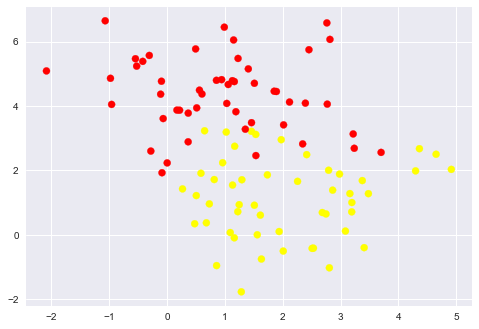

In [112]:
X,y = make_blobs(n_samples=100, centers=2,
                random_state=0, cluster_std=1.2)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')

SVM允许一些点位于边界线之内

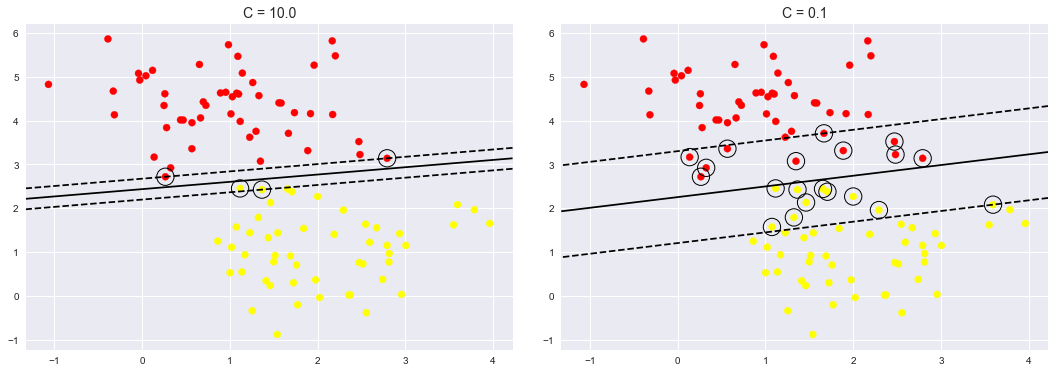

In [113]:
X,y = make_blobs(n_samples=100, centers=2,
                random_state=0, cluster_std=0.8)

fig,ax = plt.subplots(1, 2, figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

可以把C看做是一个惩罚因子，C越大，越不能容忍误分类，相应这个平面以及轮廓会比较窄，C越小就越能容忍，轮廓就会比较宽

## 案例：人脸识别

### 获取数据

In [116]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person = 60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


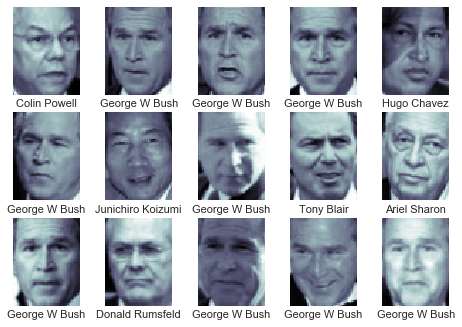

In [118]:
# 画一些人脸出来看看
fig, ax = plt.subplots(3, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], 
           xlabel=faces.target_names[faces.target[i]])


### 特征工程

In [121]:
# 用PCA提取150个特征，将预处理器和分类器打包成管道
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components = 150, whiten = True, random_state = 42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [122]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                               random_state=42)

In [123]:
from sklearn.grid_search import GridSearchCV

param_grid = {'svc__C':[1, 5, 10, 50],
             'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 24.9 s, sys: 1.03 s, total: 26 s
Wall time: 17.5 s
{'svc__C': 10, 'svc__gamma': 0.001}


In [124]:
#对测试数据进行验证
model = grid.best_estimator_
yfit = model.predict(Xtest)

Text(0.5,0.98,'Predicted Names; Incorrect Labels in Red')

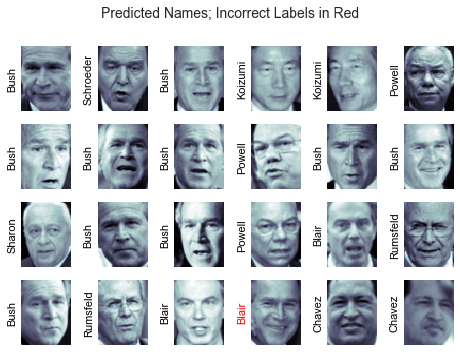

In [125]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [126]:
# 分类报告
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names = faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



/Users/vodka/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/vodka/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


Text(125.71,0.5,'predicted label')

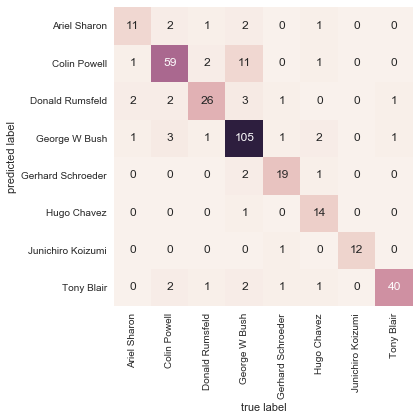

In [127]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

从上图可以看出，哪些人比较容易被分类，哪些不太容易被分类

## 支持向量机总结

### 优点
* 模型仅依赖支持向量，内存占用小
* 预测阶段速度非常快
* 对于高维数据的学习效果非常好——即使训练比样本维度还高的数据也没有问题
* 与核函数的配合极具通用性

### 缺点
* 训练复杂度不可控，大样本计算成本会非常高
* 训练效果非常依赖于边界软化参数C的选择是否合理
* 预测结果不能直接进行概率解释，这一点可以通过内部交叉验证进行评估，但是评估的计算量也很大

在一般选择模型顺序中，都排在靠后的位置